## Utilisation du Réseau Neuronal Convolutionnel de Super-Résolution
Au cours de cette présentation, nous verrons comment :

* utiliser les métriques de qualité d'image PSNR, MSE et SSIM,
* traiter les images avec OpenCV,
* convertir entre les espaces de couleur RGB, BGR et YCrCb,
* construire des réseaux neuronaux profonds avec Keras,
* déployer et évaluer le réseau SRCNN

### 1. Importation des Packages


In [1]:
import sys
import keras
import cv2
import numpy
import matplotlib
import skimage


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
import cv2
import numpy as np
import math
import os

# Fonction magique Python, affiche les chiffres du pyplot dans le cahier
%matplotlib inline

### 2. Mesures de qualité d'image

In [23]:
# définir une fonction pour "peak signal-to-noise ratio" (PSNR)
def psnr(target, ref):
         
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

# définir une fonction pour "mean squared error" (MSE)
def mse(target, ref):
    # le MSE entre les deux images est la somme de la différence au carré entre les deux images
    err = np.sum((target.astype('float') - ref.astype('float')) ** 2)
    err /= float(target.shape[0] * target.shape[1])
    
    return err

# définir une fonction qui combine les trois mesures de qualité d'image
def compare_images(target, ref):
    scores = []
    scores.append(psnr(target, ref))
    scores.append(mse(target, ref))
    window_size = 3 
    scores.append(ssim(target, ref, win_size=window_size, multichannel=True))
    return scores



### 3. Preparing Images
Pour ce projet, nous utiliserons les mêmes images que celles utilisées dans l'article original du SRCNN.

Maintenant que nous disposons de quelques images, nous souhaitons produire des versions basse résolution de ces mêmes images. Nous pouvons y parvenir en redimensionnant les images, à la fois vers le bas et vers le haut, à l'aide d'OpeCV. Il existe plusieurs méthodes d'interpolation qui peuvent être utilisées pour redimensionner les images ; cependant, nous utiliserons l'interpolation bilinéaire.

Une fois que nous produisons ces images basse résolution, nous pouvons les enregistrer dans un nouveau dossier.

In [24]:
# préparer des images dégradées en introduisant des distorsions de qualité via le redimensionnement
def prepare_images(path, factor):
    
    for file in os.listdir(path):
        
        img = cv2.imread(path + '/' + file)
        
        # find old and new image dimensions
        h, w, _ = img.shape
        new_height = h / factor
        new_width = w / factor
        
        # resize the image - down
        img = cv2.resize(img, (int(new_width), int(new_height)), interpolation = cv2.INTER_LINEAR)
        
        # resize the image - up
        img = cv2.resize(img, (w, h), interpolation = cv2.INTER_LINEAR)
        
        # save the image
        print('Saving {}'.format(file))
        cv2.imwrite('src/images/{}'.format(file), img)

In [25]:
prepare_images('src/source/', 2)

Saving baboon.bmp
Saving baby_GT.bmp
Saving bird_GT.bmp
Saving bridge.bmp
Saving butterfly_GT.bmp
Saving coastguard.bmp
Saving comic.bmp
Saving face.bmp
Saving flowers.bmp
Saving foreman.bmp
Saving head_GT.bmp
Saving man.bmp
Saving monarch.bmp
Saving outmani.jpg
Saving pepper.bmp
Saving ppt3.bmp
Saving zebra.bmp


### 3. Test des images de basse résolution
Pour garantir que nos mesures de qualité d'image sont correctement calculées et que les images ont été efficacement dégradées, calculons le PSNR, le MSE et le SSIM entre nos images de référence et les images dégradées que nous venons de préparer.

In [26]:
for file in os.listdir('src/images/'):
    
    # images cibles et de référence ouvertes
    target = cv2.imread('src/images/{}'.format(file))
    ref = cv2.imread('src/source/{}'.format(file))
    
    # calculer le score
    scores = compare_images(target, ref)

    # afficher les trois scores 
    print('{}\nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(file, scores[0], scores[1], scores[2]))

baboon.bmp
PSNR: 22.157084083442548
MSE: 1187.1161333333334
SSIM: 0.7528278896413736

baby_GT.bmp
PSNR: 34.37180640966199
MSE: 71.28874588012695
SSIM: 0.9728221267664166

bird_GT.bmp
PSNR: 32.896644728720005
MSE: 100.12375819830247
SSIM: 0.98402170780111

bridge.bmp
PSNR: 25.850528790115554
MSE: 507.1643714904785
SSIM: 0.6807839757023728

butterfly_GT.bmp
PSNR: 24.782076560337416
MSE: 648.6254119873047
SSIM: 0.9317368387988169

coastguard.bmp
PSNR: 27.161600663887082
MSE: 375.00887784090907
SSIM: 0.7302381334987362

comic.bmp
PSNR: 23.799861502225532
MSE: 813.2338836565096
SSIM: 0.8230754121380186

face.bmp
PSNR: 30.99220650287191
MSE: 155.23189718546524
SSIM: 0.9161926811860451

flowers.bmp
PSNR: 27.454504805386147
MSE: 350.55093922651935
SSIM: 0.9140532803578405

foreman.bmp
PSNR: 30.14456532664372
MSE: 188.6883483270202
SSIM: 0.9569716723433118

head_GT.bmp
PSNR: 31.020502848237534
MSE: 154.2237755102041
SSIM: 0.9161446058644955

man.bmp
PSNR: 27.22646369798821
MSE: 369.449638366699

### 4. Construction du modèle SRCNN
Maintenant que nous avons nos images de basse résolution et que les trois mesures de qualité d'image fonctionnent correctement, nous pouvons commencer à construire le modèle SRCNN.

In [27]:
# définir le modèle SRCNN
def model():
    
    SRCNN = Sequential()
    
    # ajouter des calques de modèle
    SRCNN.add(Conv2D(filters = 128, kernel_size = (9, 9), kernel_initializer='glorot_uniform',
                     activation='relu', padding='valid', use_bias=True, input_shape=(None, None, 1)))
    SRCNN.add(Conv2D(filters = 64, kernel_size = (3, 3), kernel_initializer='glorot_uniform',
                     activation='relu', padding='same', use_bias=True))
    SRCNN.add(Conv2D(filters = 1, kernel_size = (5, 5), kernel_initializer='glorot_uniform',
                     activation='linear', padding='valid', use_bias=True))
    
    # définir l'optimiseur
    adam = Adam(learning_rate = 0.0003)
    
    # compiler le modèle
    SRCNN.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return SRCNN

### 5. Déploiement du SRCNN
Maintenant que nous avons défini notre modèle, nous pouvons l'utiliser pour la super-résolution d'images individuelles. Cependant, avant de le faire, nous devrons définir quelques fonctions de traitement d'image. De plus, il sera nécessaire de prétraiter les images de manière approfondie avant de les utiliser comme entrées pour le réseau. Ce traitement inclura le recadrage(cropping) et les conversions d'espace colorimétrique.
### Transfer Learning
De plus, pour l'entraînement , nous chargerons des poids pré-entraînés pour le SRCNN. Ces poids peuvent être trouvés sur la page GitHub suivante : https://github.com/MarkPrecursor/SRCNN-keras

Une fois que nous aurons testé notre réseau, nous pourrons effectuer une super-résolution d'image unique sur toutes nos images d'entrée. En outre, après le traitement, nous pourrons calculer le PSNR, le MSE et le SSIM sur les images que nous produisons.


In [28]:
# définir les fonctions de traitement d'image nécessaires
def modcrop(img, scale):
    tmpsz = img.shape
    sz = tmpsz[0:2]
    sz = sz - np.mod(sz, scale)
    img = img[0:sz[0], 1:sz[1]]
    return img


def shave(image, border):
    img = image[border: -border, border: -border]
    return img

In [29]:
# définir la fonction de prédiction principale

def predict(image_path):
    
    # charger le modèle srcnn avec des poids
    srcnn = model()
    srcnn.load_weights('src/models/3051crop_weight_200.h5')
    
    # charger les images dégradées et de référence
    path, file = os.path.split(image_path)
    degraded = cv2.imread(image_path)
    ref = cv2.imread('src/source/{}'.format(file))
    
    # prétraiter l'image avec modcrop
    ref = modcrop(ref, 3)
    degraded = modcrop(degraded, 3)
    
    # convertir l'image en YCrCb - (srcnn formé sur le canal Y)
    temp = cv2.cvtColor(degraded, cv2.COLOR_BGR2YCrCb)
    
    # créer une tranche d'image et normaliser 
    Y = numpy.zeros((1, temp.shape[0], temp.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = temp[:, :, 0].astype(float) / 255
    
    # effectuer une super-résolution avec srcnn
    pre = srcnn.predict(Y, batch_size=1)
    
    # post-process de la sortie
    pre *= 255
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(np.uint8)
    
    # copier le canal Y dans l'image et le convertir en BGR
    temp = shave(temp, 6)
    temp[:, :, 0] = pre[0, :, :, 0]
    output = cv2.cvtColor(temp, cv2.COLOR_YCrCb2BGR)
    
    # supprimer la bordure de la référence et de l'image dégradée
    ref = shave(ref.astype(np.uint8), 6)
    degraded = shave(degraded.astype(np.uint8), 6)
    
    # calculs de qualité d'image
    scores = []
    scores.append(compare_images(degraded, ref))
    scores.append(compare_images(output, ref))
    
    # retourner les images et les scores
    return ref, degraded, output, scores

1/1 [==============================] - 10s 10s/step
Degraded Image: 
PSNR: 44.62779471199959
MSE: 6.720818147606527
SSIM: 0.9948096638197194

Reconstructed Image: 
PSNR: 46.01870741045615
MSE: 4.879000633948845
SSIM: 0.9949343170541501



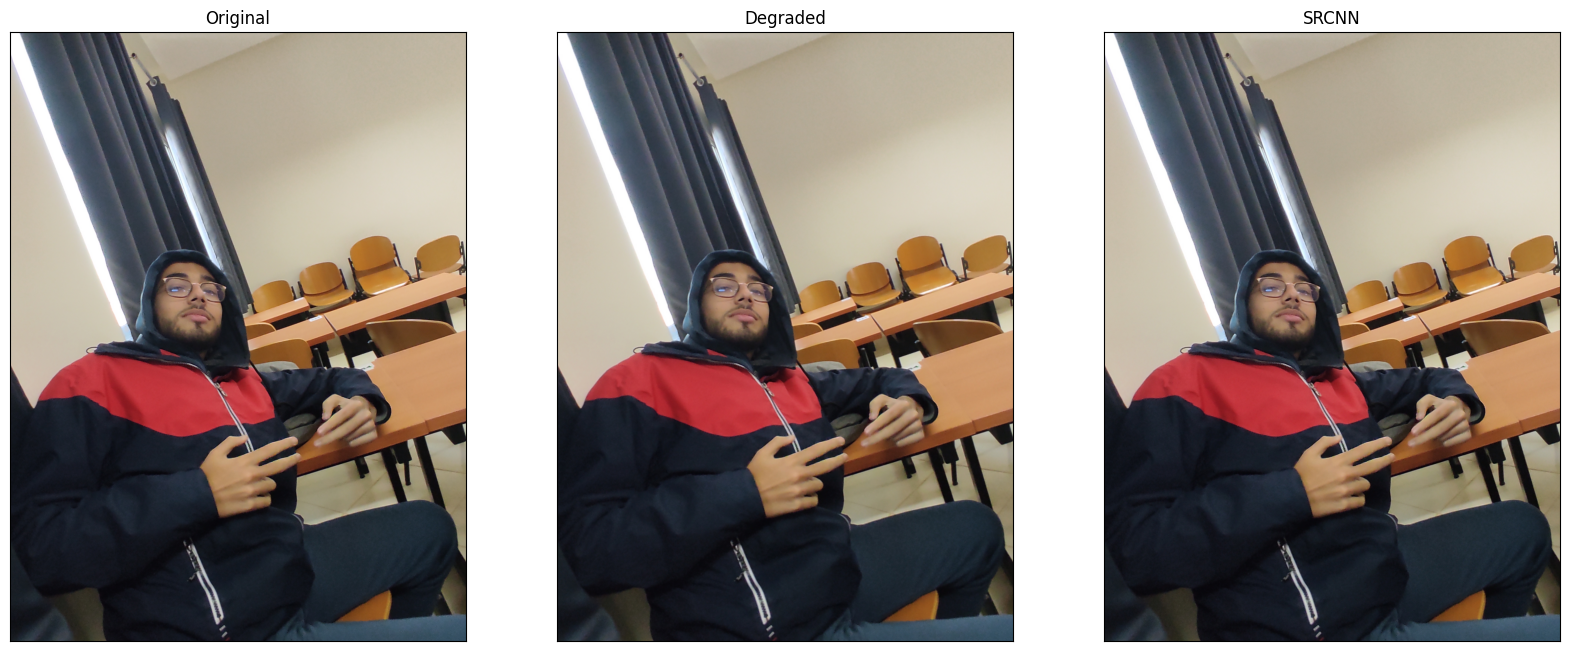

In [30]:
ref, degraded, output, scores = predict('src/images/outmani.jpg')

# print all scores for all images
print('Degraded Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[0][0], scores[0][1], scores[0][2]))
print('Reconstructed Image: \nPSNR: {}\nMSE: {}\nSSIM: {}\n'.format(scores[1][0], scores[1][1], scores[1][2]))


# display images as subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
axs[0].set_title('Original')
axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
axs[1].set_title('Degraded')
axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
axs[2].set_title('SRCNN')

# remove the x and y ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

In [31]:
for file in os.listdir('images'):
    
    #effectuer une super-résolution
    ref, degraded, output, scores = predict('src/images/{}'.format(file))
    
    # afficher les images sous forme de sobplots
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs[0].imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original')
    axs[1].imshow(cv2.cvtColor(degraded, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Degraded')
    axs[1].set(xlabel = 'PSNR: {}\nMSE: {} \nSSIM: {}'.format(scores[0][0], scores[0][1], scores[0][2]))
    axs[2].imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB))
    axs[2].set_title('SRCNN')
    axs[2].set(xlabel = 'PSNR: {} \nMSE: {} \nSSIM: {}'.format(scores[1][0], scores[1][1], scores[1][2]))

    # remove the x and y ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
      
    print('Saving {}'.format(file))
    fig.savefig('src/output/{}.png'.format(os.path.splitext(file)[0])) 
    plt.close()

1/1 [==============================] - 1s 628ms/step
Saving baboon.bmp
1/1 [==============================] - 1s 697ms/step
Saving baby_GT.bmp
1/1 [==============================] - 0s 455ms/step
Saving bird_GT.bmp
1/1 [==============================] - 1s 654ms/step
Saving bridge.bmp
1/1 [==============================] - 0s 480ms/step
Saving butterfly_GT.bmp
1/1 [==============================] - 1s 501ms/step
Saving coastguard.bmp
1/1 [==============================] - 1s 521ms/step
Saving comic.bmp
1/1 [==============================] - 0s 441ms/step
Saving face.bmp
1/1 [==============================] - 1s 617ms/step
Saving flowers.bmp
1/1 [==============================] - 1s 534ms/step
Saving foreman.bmp
1/1 [==============================] - 0s 471ms/step
Saving head_GT.bmp
1/1 [==============================] - 1s 665ms/step
Saving man.bmp
1/1 [==============================] - 1s 837ms/step
Saving monarch.bmp
1/1 [==============================] - 10s 10s/step
Saving outmani.